# Jax experinment

## Sympy

In [1]:
import sympy as sp

# Define symbols
t = sp.Symbol('t')  # time
m = sp.Symbol('m', positive=True)  # mass of the quadrotor
I = sp.Symbol('I', positive=True)  # moment of inertia
g = sp.Symbol('g', positive=True)  # gravitational acceleration
thrust = sp.Function('thrust')(t)  # thrust force
tau = sp.Function('tau')(t)  # torque

# Define state variables and their derivatives
x, y, theta = sp.symbols('x y theta', cls=sp.Function)
x = x(t)
y = y(t)
theta = theta(t)

x_dot = x.diff(t)
y_dot = y.diff(t)
theta_dot = theta.diff(t)

x_ddot = x_dot.diff(t)
y_ddot = y_dot.diff(t)
theta_ddot = theta_dot.diff(t)

# Equations of motion (Newton's second law and torque equation)
eq_x = sp.Eq(x_ddot, thrust / m * sp.sin(theta))
eq_y = sp.Eq(y_ddot, thrust / m * sp.cos(theta) - g)
eq_theta = sp.Eq(I * theta_ddot, tau)

# Solve for second-order derivatives
sol = sp.solve((eq_x, eq_y, eq_theta), (x_ddot, y_ddot, theta_ddot))
print(sol)

quadrotor_dynamics = sp.lambdify((x, y, theta, x_dot, y_dot, theta_dot, thrust, tau, m, I, g), list(sol.values()), 'jax')
print(quadrotor_dynamics(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11))

{Derivative(x(t), (t, 2)): thrust(t)*sin(theta(t))/m, Derivative(y(t), (t, 2)): -g + thrust(t)*cos(theta(t))/m, Derivative(theta(t), (t, 2)): tau(t)/I}
[Array(0.10976, dtype=float32, weak_type=True), Array(-11.769994, dtype=float32, weak_type=True), 0.8]


## Environment

In [2]:
import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct


@struct.dataclass
class EnvState:
    x: float
    y: float
    theta: float
    x_dot: float
    y_dot: float
    theta_dot: float
    last_thrust: float  # Only needed for rendering
    last_tau: float  # Only needed for rendering
    time: int


@struct.dataclass
class EnvParams:
    max_speed: float = 8.0
    max_torque: float = 500.0
    max_thrust: float = 20.0
    dt: float = 0.1
    g: float = 9.81  # gravity
    m: float = 1.0  # mass
    I: float = 1.0  # moment of inertia
    max_steps_in_episode: int = 50


class Quad2D(environment.Environment):
    """
    JAX Compatible version of Quad2D-v0 OpenAI gym environment. Source:
    github.com/openai/gym/blob/master/gym/envs/classic_control/Quad2D.py
    """

    def __init__(self):
        super().__init__()
        self.obs_shape = (3,)

    @property
    def default_params(self) -> EnvParams:
        """Default environment parameters for Quad2D-v0."""
        return EnvParams()

    def step_env(
        self,
        key: chex.PRNGKey,
        state: EnvState,
        action: float,
        params: EnvParams,
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        """Integrate Quad2D ODE and return transition."""
        thrust = (action[0]+1.0)/2.0 * params.max_thrust
        tau = action[1] * params.max_torque
        reward = 1.0 - (
            0.002 * angle_normalize(state.theta) ** 2 # zero angle
            + 0.00003 * state.theta_dot ** 2 # zero angular velocity
            + 0.3 * (state.x ** 2 + state.y ** 2) # close to center
            + 0.03 * (state.x_dot ** 2 + state.y_dot ** 2) # zero velocity          
        )
        reward = reward.squeeze()

        s_dot = quadrotor_dynamics(
            state.x, state.y, state.theta, state.x_dot, state.y_dot, state.theta_dot, 
            thrust, tau, 
            params.m, params.I, params.g)
        new_x_dot = state.x_dot + params.dt * s_dot[0]
        new_y_dot = state.y_dot + params.dt * s_dot[1]
        new_th_dot = state.theta_dot + params.dt * s_dot[2]
        new_x = state.x + params.dt * new_x_dot
        new_y = state.y + params.dt * new_y_dot
        new_th = state.theta + params.dt * new_th_dot

        # Update state dict and evaluate termination conditions
        state = EnvState(
            x=new_x,
            y=new_y,
            x_dot=new_x_dot,
            y_dot=new_y_dot,
            theta=new_th,
            theta_dot=new_th_dot,
            last_thrust=thrust,
            last_tau=tau,
            time=state.time + 1,
        )
        done = self.is_terminal(state, params)
        return (
            lax.stop_gradient(self.get_obs(state)),
            lax.stop_gradient(state),
            reward,
            done,
            {"discount": self.discount(state, params)},
        )

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Reset environment state by sampling theta, theta_dot."""
        high = jnp.array([1, 1, jnp.pi/3])
        rand_val = jax.random.uniform(key, shape=(3,), minval=-high, maxval=high)
        state = EnvState(
            x=rand_val[0], 
            y=rand_val[1],
            theta= rand_val[2],
            x_dot=0.0,
            y_dot=0.0,
            theta_dot=0.0,
            last_thrust=0.0,
            last_tau=0.0,
            time=0,
        )
        return self.get_obs(state), state

    def get_obs(self, state: EnvState) -> chex.Array:
        """Return angle in polar coordinates and change."""
        return jnp.array(
            [
                state.x, 
                state.y,
                angle_normalize(state.theta),
                state.x_dot / 4.0,
                state.y_dot / 4.0,
                state.theta_dot / 40.0,
            ]
        ).squeeze()

    def is_terminal(self, state: EnvState, params: EnvParams) -> bool:
        """Check whether state is terminal."""
        # Check number of steps in episode termination condition
        done = (state.time >= params.max_steps_in_episode) | (jnp.abs(state.x) > 2.0) | (jnp.abs(state.y) > 2.0)
        return done

    @property
    def name(self) -> str:
        """Environment name."""
        return "Quad2D-v1"

    @property
    def num_actions(self) -> int:
        """Number of actions possible in environment."""
        return 2

    def action_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        """Action space of the environment."""
        if params is None:
            params = self.default_params
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(2,),
            dtype=jnp.float32,
        )

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        high = jnp.array([1.0, 1.0, jnp.pi, 4.0, 4.0, 40.0], dtype=jnp.float32)
        return spaces.Box(-high, high, shape=(6,), dtype=jnp.float32)

    def state_space(self, params: EnvParams) -> spaces.Dict:
        """State space of the environment."""
        return spaces.Dict(
            {
                "x": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "y": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "x_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "y_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "theta": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "theta_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "last_thrust": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "last_tau": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )


def angle_normalize(x: float) -> float:
    """Normalize the angle - radians."""
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi

/home/pcy/miniconda3/envs/jax/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


### Test Env

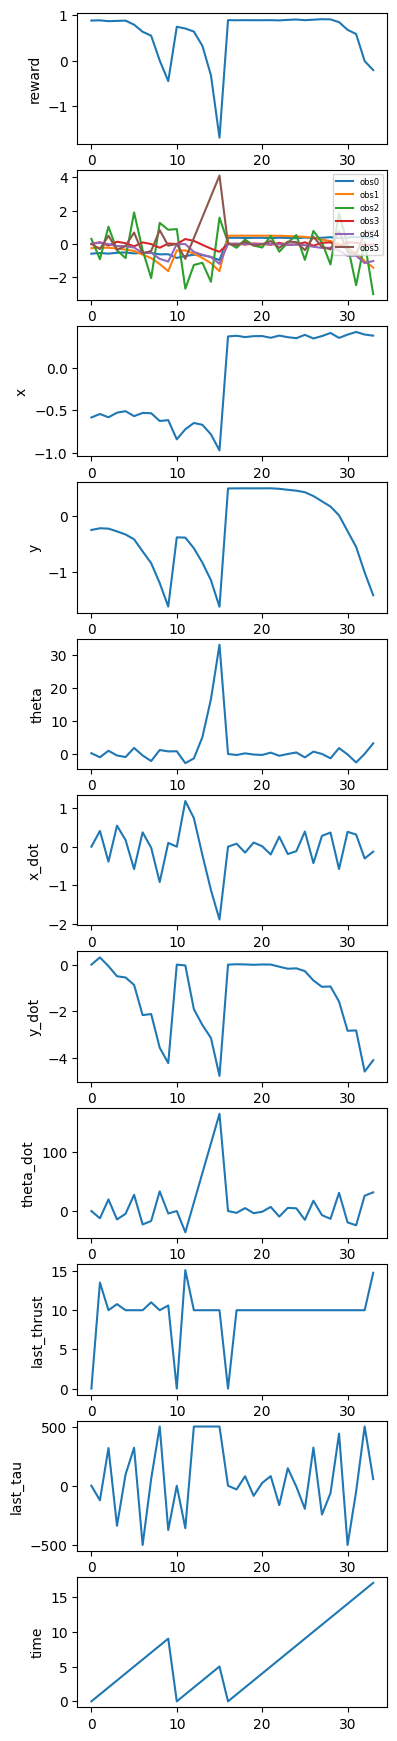

In [3]:
def test_env(env, policy):
    env_params = env.default_params
    rng = jax.random.PRNGKey(2)

    state_seq, obs_seq, reward_seq = [], [], []
    rng, rng_reset = jax.random.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)
    n_dones = 0
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)
        action = policy(obs, rng_act)
        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state, action, env_params
        )
        reward_seq.append(reward)
        obs_seq.append(obs)
        if done:
            n_dones += 1
        obs = next_obs
        env_state = next_env_state
        if n_dones >= 3:
            break

    import matplotlib.pyplot as plt
    num_figs = len(state_seq[0].__dict__) + 2
    # create num_figs subplots
    plt.subplots(num_figs, 1, figsize=(4, 2 * num_figs))
    # plot reward
    plt.subplot(num_figs, 1, 1)
    plt.plot(reward_seq)
    plt.ylabel("reward")
    # plot obs
    plt.subplot(num_figs, 1, 2)
    for i in range(len(obs_seq[0])):
        plt.plot([o[i] for o in obs_seq], label=f"obs{i}")
        plt.legend(fontsize=6)
    # enumerate states's attributes (state is EnvParams dataclass)
    for i, (k, v) in enumerate(state_seq[0].__dict__.items()):
        plt.subplot(num_figs, 1, i + 3)
        plt.plot([s.__dict__[k] for s in state_seq])
        plt.ylabel(k)

env = Quad2D()
random_policy = lambda obs, rng: env.action_space(env.default_params).sample(rng)
def pid_policy(obs, rng):
    x = obs[0]
    y = obs[1]
    theta = obs[2]
    x_dot = obs[3] * 4.0
    y_dot = obs[4] * 4.0
    theta_dot = obs[5] * 4.0
    tau = - 1.0 * (400.0 * theta - 40.0 * theta_dot)
    target_force_x = - 1.0 * (10.0 * x - 1.0 * x_dot)
    target_force_y = - 1.0 * (10.0 * y - 1.0 * y_dot) + 9.81 * 1.0
    thrust = target_force_x * jnp.sin(theta) + target_force_y * jnp.cos(theta)
    # convert into action space
    thrust_normed = jnp.clip(thrust/20.0 * 2.0 - 1.0, 0.0, 1.0)
    tau_normed =jnp.clip(tau/500.0, -1, 1)
    return jnp.array([thrust_normed, tau_normed])
test_env(env, policy=pid_policy)

## Train

### make function

In [4]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.environments import environment, spaces
from brax.envs.wrappers import training
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env= Quad2D()
    env_params = env.default_params 
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space(env_params).shape[0], activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0,None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


In [5]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 2048,
    "NUM_STEPS": 10,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 32,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ANNEAL_LR": True,
}

### train

jit time: 0.00 s
train time: 9.67 s


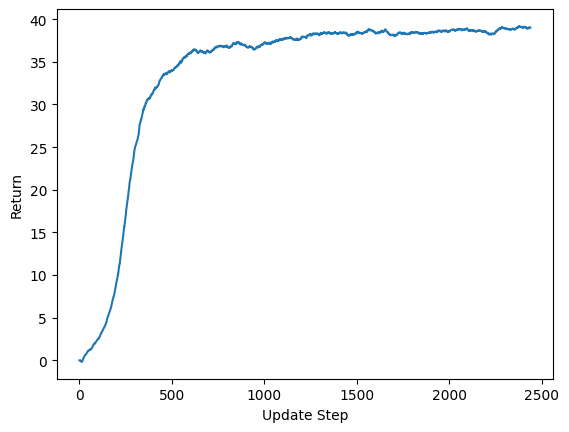

In [6]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
train_jit = jax.jit(make_train(config))
print(f"jit time: {time.time() - t0:.2f} s")
t0 = time.time()
out = jax.block_until_ready(train_jit(rng))
print(f"train time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [7]:
# save network params
import pickle
with open("../results/ppo_params.pkl", "wb") as f:
    pickle.dump(out["runner_state"][0].params, f)

### evaluate enviroment

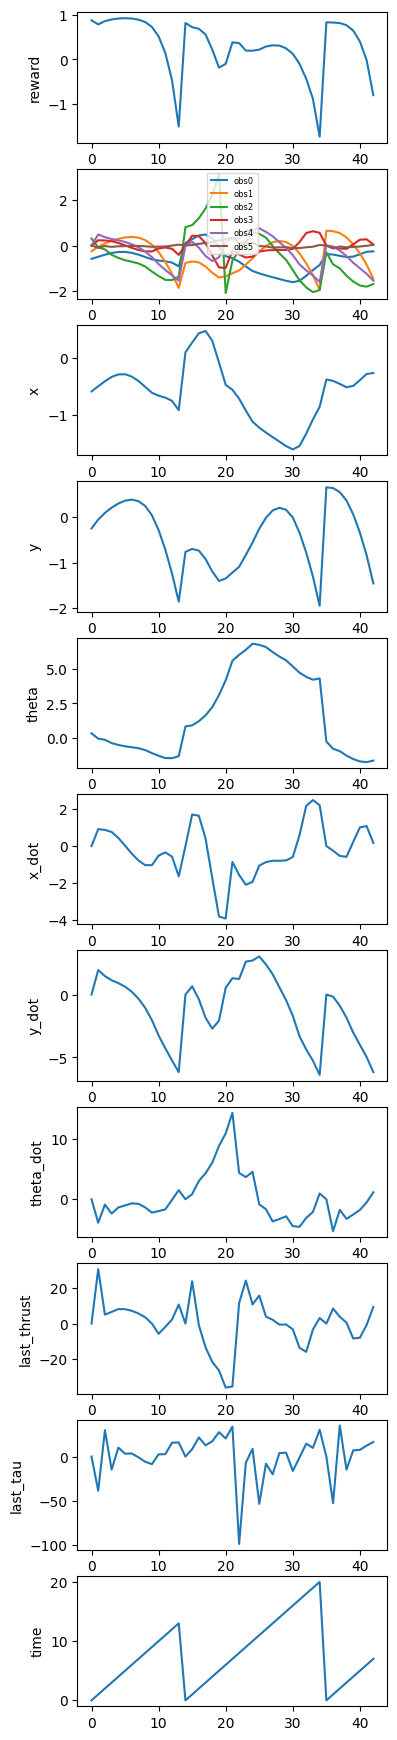

In [8]:
rng = jax.random.PRNGKey(1)
env = Quad2D()
apply_fn = out['runner_state'][0].apply_fn
params= out['runner_state'][0].params
def policy(obs, rng):
    return apply_fn(params, obs)[0].mean()
env.reset(rng)
# test policy
test_env(env, policy=policy)